# Environment

In [11]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import gc

# Get the current working directory
# wd_dir = os.getcwd()

wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET/Multiome_SETBP1'
os.chdir(wd_dir)

# Construct the path to the parent directory
parent_dir = os.path.abspath(os.path.join(wd_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

# Add path to Helper.py
sys.path.insert(0, "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET")

import Helper as fn

# Load data

In [12]:
# Set the path to the directory containing the cellranger output
# base_path = "Multiome_SETBP1/all"
base_path = "Multiome_SETBP1"

# Define the sample directories based on the output
sample_dirs = [
    # "AGG_Setbp1_hSETBP1",   # Libraries aggregated: (Embryo_Ctrl_hSETBP1, Embryo_Mut_hSETBP1), (P2_Ctrl_hSETBP1, P2_Mut_hSETBP1) 
    # "AGG_Setbp1",           # Libraries aggregated: (Embryo_Ctrl, Embryo_Mut), (P2_Ctrl, P2_Mut) 
    # "AGG_Setbp1_correct"   # Libraries aggregated: (embryo_mut, embryo_ctrl), (P2_Ctrl_hSETBP1, P2_Mut_hSETBP1) 
    "ATAC_CRE_Plus_embrioni/Embryo_Mut_hSETBP1",
    "ATAC_CRE_Plus_embrioni/Embryo_Mut",
    "ATAC_CRE_Plus_embrioni/embryo_ctrl",
    "ATAC__CRE_Minus_embrioni/Embryo_Ctrl",
    "ATAC__CRE_Minus_embrioni/Embryo_Ctrl_hSETBP1",
    "ATAC__CRE_Minus_embrioni/embryo_mut",
    "ATAC_ctrl_neonati/P2_Ctrl_hSETBP1",
    "ATAC_ctrl_neonati/P2_Ctrl",
    "ATAC_mutato_neonati/P2_Mut",
    "ATAC_mutato_neonati/P2_Mut_hSETBP1"
]

In [18]:
# Load and combine data from all samples, separating by stage
adata_embryo_list = []
adata_P2_list = []

for sample in sample_dirs:
    sample_path = os.path.join(base_path, sample, "outs", "filtered_feature_bc_matrix")
    adata = sc.read_10x_mtx(sample_path, var_names='gene_symbols', cache=True)
    adata.obs['sample'] = sample
    adata.obs['condition'] = 'control' if 'Ctrl' in sample or 'ctrl' in sample else 'mutant'
    adata.obs['stage'] = 'embryo' if 'embryo' in sample.lower() else 'P2'
    adata.obs['hSETBP1'] = 'yes' if 'hSETBP1' in sample else 'no'
    
    if 'embryo' in sample.lower():
        adata_embryo_list.append(adata)
    else:
        adata_P2_list.append(adata)

In [60]:
# Concatenate all samples into a single AnnData object
adata_embryo = ad.concat(adata_embryo_list, label="sample", index_unique="-")
adata_P2 = ad.concat(adata_P2_list, label="sample", index_unique="-")

In [61]:
print(adata_embryo.shape)
print(adata_P2.shape)

(26613, 32285)
(50980, 32285)


In [62]:
print(adata_embryo.var_names[:10])
print(adata_P2.var_names[:10])

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1'],
      dtype='object')
Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1'],
      dtype='object')


In [63]:
print("A couple of non-zero elements from the matrix:")
non_zero = adata_embryo.X.data[:10]
print(non_zero)

A couple of non-zero elements from the matrix:
[ 1.  1.  2.  1.  1.  1. 13.  1.  1.  3.]


In [66]:
# Calculate QC metrics
mito_genes = adata_embryo.var_names.str.startswith(('mt-', 'Mt-', 'MT-'))   
ribo_genes = adata_embryo.var_names.str.contains('^Rps|^Rpl')

adata_embryo.var['mito'] = mito_genes
adata_embryo.var['ribo'] = ribo_genes

sc.pp.calculate_qc_metrics(adata_embryo, log1p=True, qc_vars=['mito','ribo'], 
                           inplace=True, percent_top=None)

adata_embryo.obs['gene_UMI_ratio'] = adata_embryo.obs['n_genes_by_counts'] / adata_embryo.obs['total_counts']
adata_embryo.obs['log1p_gene_UMI_ratio'] = np.log1p(adata_embryo.obs['gene_UMI_ratio'])

In [67]:
#Cell filtering
MIN_GENES = 800
MAX_GENES = 6000

MIN_COUNTS = 1500
MAX_COUNTS = 25000

PCT_MITO = 20
PCT_RIBO = 30

#Gene Filtering
PCT_CELLS = 0.25

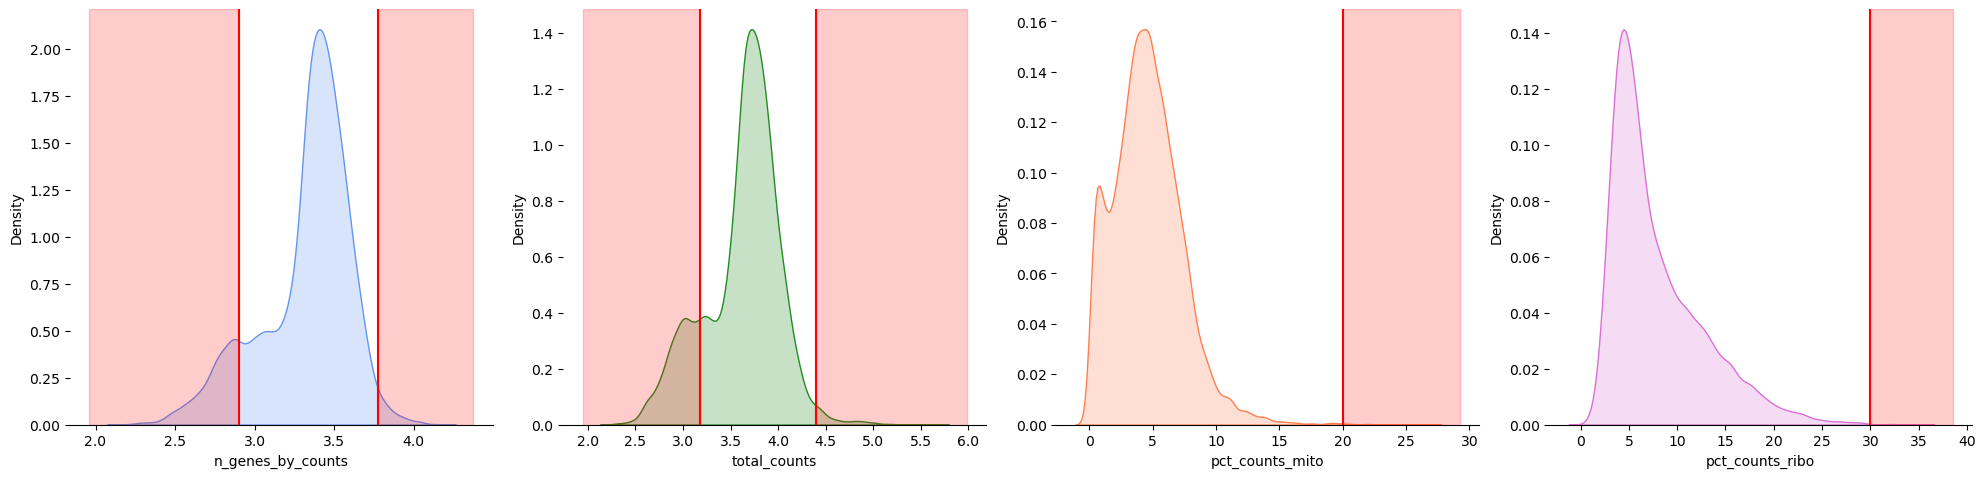

In [68]:
fn.densityQCs(adataObj = adata_embryo, hue=None, 
              min_counts = MIN_COUNTS, max_counts = MAX_COUNTS, 
              min_genes = MIN_GENES, max_genes = MAX_GENES, 
              pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

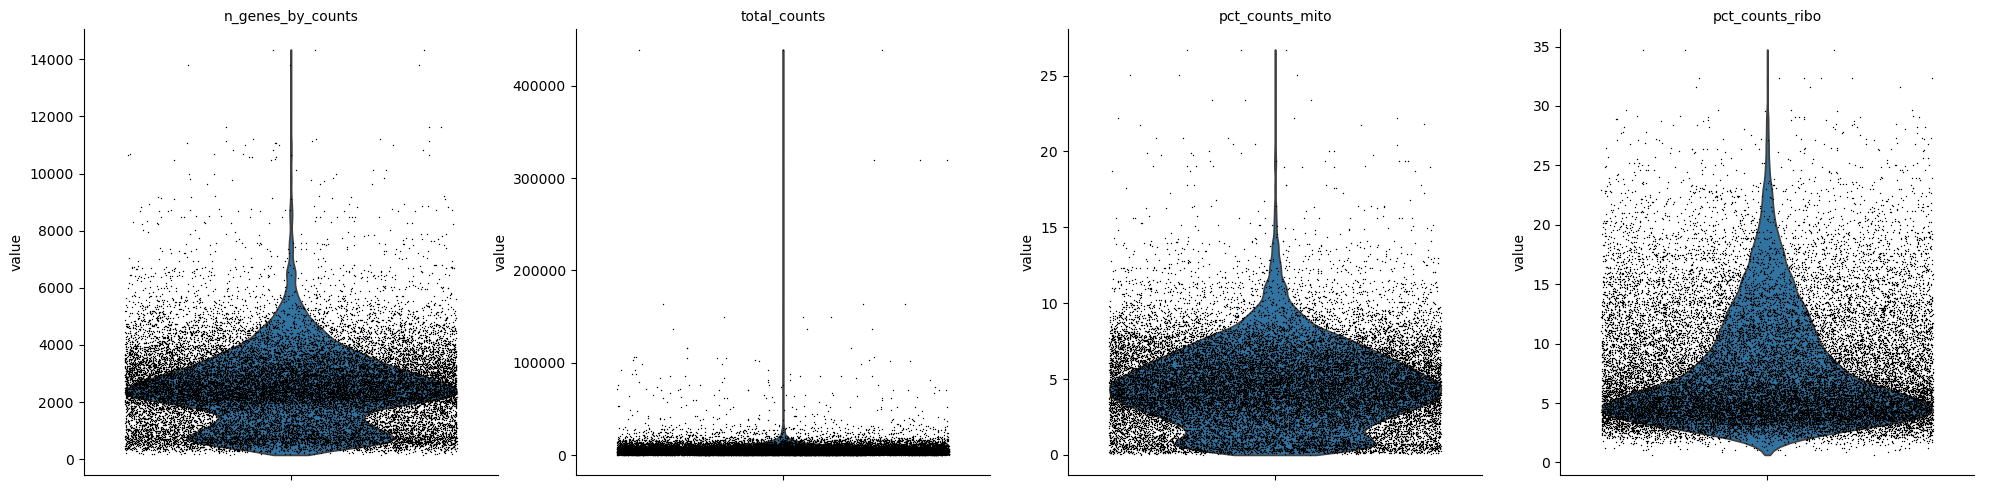

In [69]:
# Plot QC metrics
sc.pl.violin(adata_embryo, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'], 
            jitter=0.4, multi_panel=True)


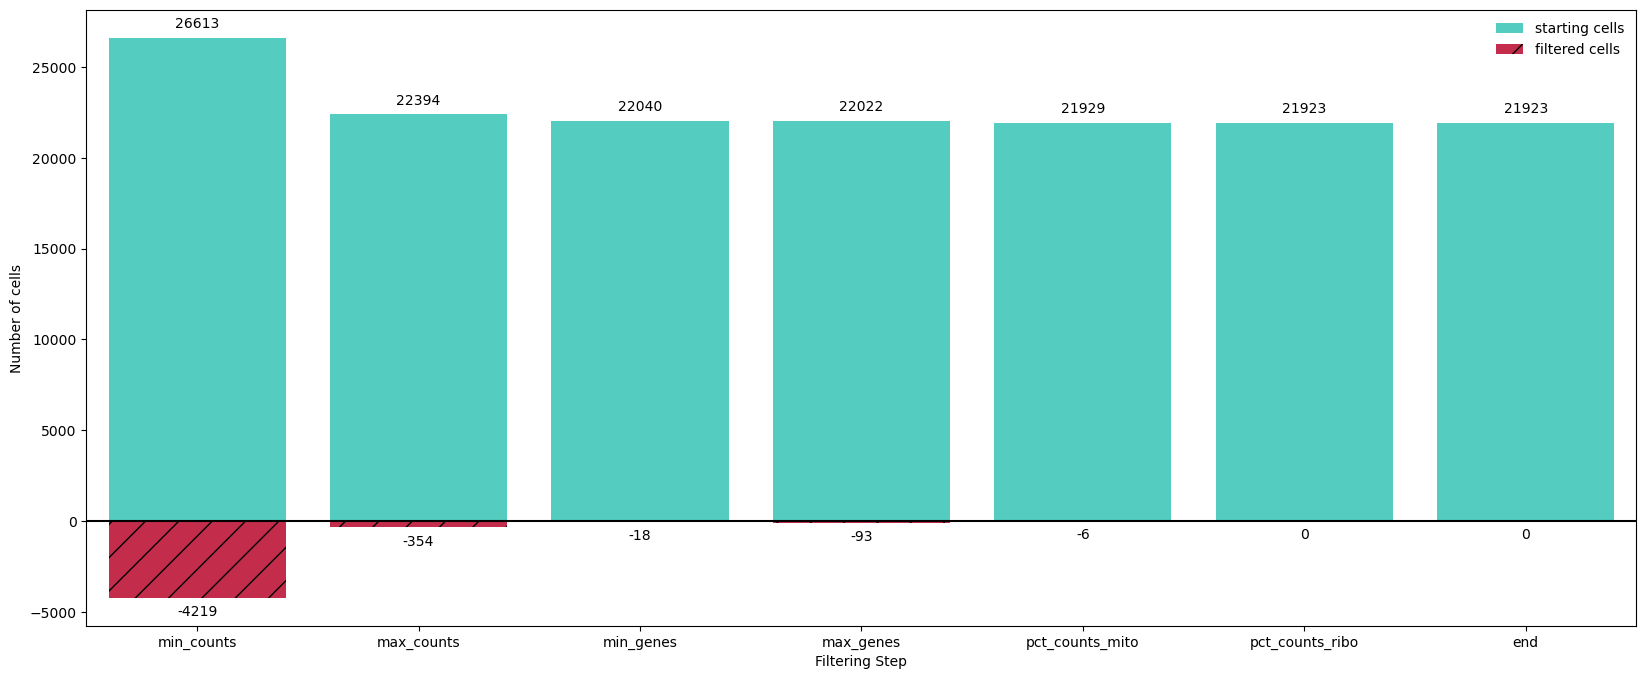

In [70]:
fn.filterCellBarplot(adataObj=adata_embryo,
                     min_counts=MIN_COUNTS, max_counts=MAX_COUNTS,
                     min_genes=MIN_GENES, max_genes=MAX_GENES,
                     pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

In [71]:
gc.collect()

14859

In [72]:
print('\nThe selected filtering parameters are:' 
      '\n Minimum counts: ' , MIN_COUNTS, '\n Maximum counts:' , MAX_COUNTS,
      '\n Minimum genes: ' , MIN_GENES, '\n Maximum genes:' , MAX_GENES,
      '\n Mitocondia: ' , PCT_MITO, '%', '\n Ribosomal: ', PCT_RIBO, '%')

sc.pp.filter_cells(adata_embryo, min_genes=MIN_GENES)
sc.pp.filter_cells(adata_embryo, max_genes=MAX_GENES)
print('After filtering detected genes: number of cells:', adata_embryo.n_obs)

sc.pp.filter_cells(adata_embryo, min_counts = MIN_COUNTS)
sc.pp.filter_cells(adata_embryo, max_counts = MAX_COUNTS)
print('After filtering on min UMI counts:number of cells:', adata_embryo.n_obs)

adata_embryo = adata_embryo[adata_embryo.obs['pct_counts_mito'] < PCT_MITO, :]
print('After filtering on mitochondrial RNA: number of cells:', adata_embryo.n_obs)

adata_embryo = adata_embryo[adata_embryo.obs['pct_counts_ribo'] < PCT_RIBO, :]
print('After filtering on ribosomal protein RNA: number of cells:', adata_embryo.n_obs)

MIN_CELLS = np.rint((adata_embryo.n_obs*PCT_CELLS)/100) 
print('\nGene expressed in less than ', PCT_CELLS, '% cells, corresponding to a number of ', 
     MIN_CELLS, ', are filtered out.')

print('Before gene filtering: number of genes:', adata_embryo.n_vars)
sc.pp.filter_genes(adata_embryo, min_cells=MIN_CELLS)
print('After gene filtering: number of genes:', adata_embryo.n_vars)


The selected filtering parameters are:
 Minimum counts:  1500 
 Maximum counts: 25000 
 Minimum genes:  800 
 Maximum genes: 6000 
 Mitocondia:  20 % 
 Ribosomal:  30 %
filtered out 3042 cells that have less than 800 genes expressed
filtered out 438 cells that have more than 6000 genes expressed
After filtering detected genes: number of cells: 23133
filtered out 1195 cells that have less than 1500 counts
filtered out 9 cells that have more than 25000 counts
After filtering on min UMI counts:number of cells: 21929
After filtering on mitochondrial RNA: number of cells: 21923
After filtering on ribosomal protein RNA: number of cells: 21923

Gene expressed in less than  0.25 % cells, corresponding to a number of  55.0 , are filtered out.
Before gene filtering: number of genes: 32285
filtered out 15279 genes that are detected in less than 55.0 cells


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After gene filtering: number of genes: 17006


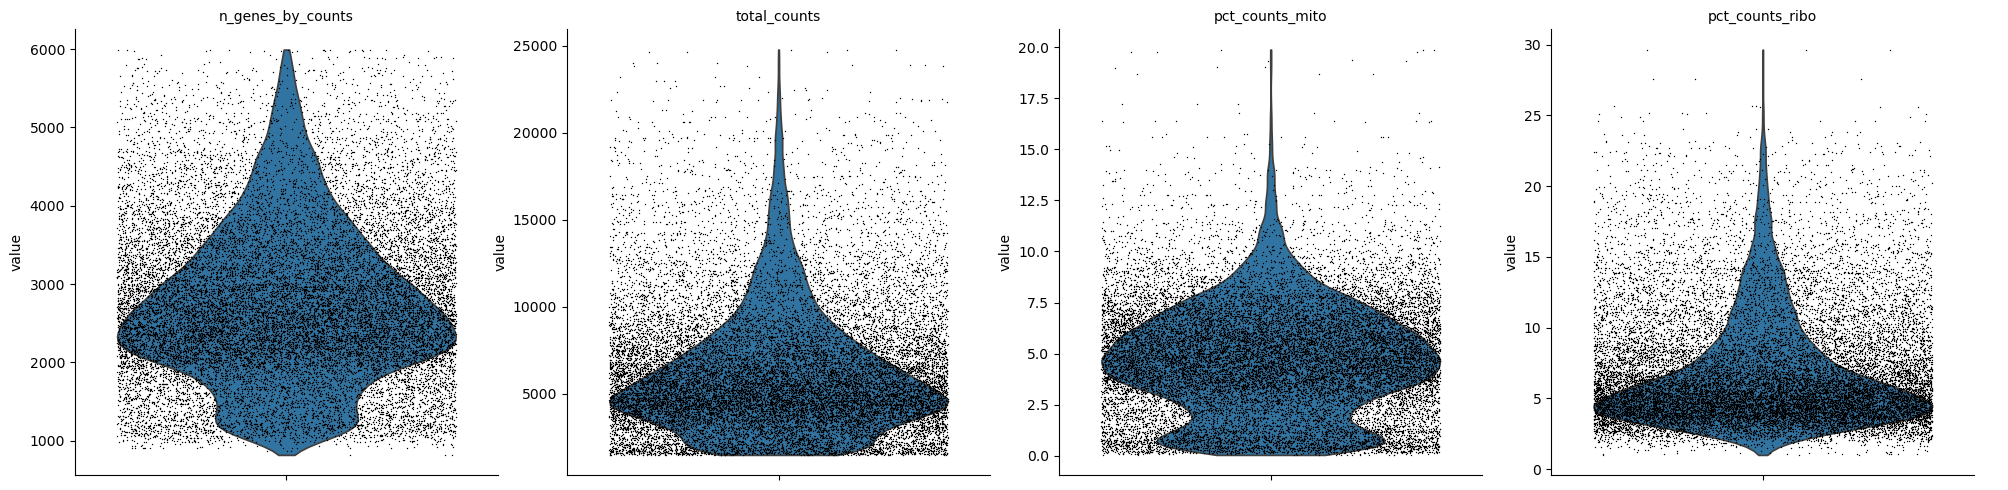

In [73]:
# Plot QC metrics
sc.pl.violin(adata_embryo, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'], 
            jitter=0.4, multi_panel=True)


In [74]:
# Save the filtered data
adata_embryo.write('./output/filtered_data_embryo.h5ad')

In [75]:
# Load the filtered data back
adata_embryo = sc.read('./output/filtered_data_embryo.h5ad')

In [76]:
adata_embryo.obs.head()

,sample,condition,stage,hSETBP1,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,gene_UMI_ratio,log1p_gene_UMI_ratio,n_genes,n_counts
AAACAGCCATCTTGAG-1-0,0,mutant,embryo,yes,2274,7.729735,4905.0,8.498215,415.0,6.030685,8.460754,243.0,5.497168,4.954128,0.463609,0.380905,2274,4905.0
AAACATGCATCACTTC-1-0,0,mutant,embryo,yes,4301,8.366835,10150.0,9.225327,115.0,4.753590,1.133005,418.0,6.037871,4.118227,0.423744,0.353290,4301,10150.0
AAACATGCATCCCGCT-1-0,0,mutant,embryo,yes,2083,7.642044,3632.0,8.197814,143.0,4.969813,3.937225,241.0,5.488938,6.635462,0.573513,0.453311,2083,3632.0
AAACATGCATCGTTCT-1-0,0,mutant,embryo,yes,2362,7.767687,4235.0,8.351375,146.0,4.990433,3.447462,208.0,5.342334,4.911452,0.557733,0.443232,2362,4235.0
AAACCAACACAAAGGT-1-0,0,mutant,embryo,yes,1848,7.522400,3425.0,8.139149,186.0,5.231109,5.430657,552.0,6.315358,16.116789,0.539562,0.431498,1848,3425.0


In [77]:
print("A couple of non-zero elements from the matrix:")
non_zero = adata_embryo.X.data[:10]
print(non_zero)

A couple of non-zero elements from the matrix:
[ 1.  1.  2.  1.  1.  1. 13.  1.  1.  3.]


In [78]:
sc.pp.normalize_total(adata_embryo, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [79]:
sc.pp.log1p(adata_embryo)

In [80]:
sc.pp.highly_variable_genes(adata_embryo, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [81]:
sc.pp.scale(adata_embryo, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [82]:
# Perform dimensionality reduction and clustering
sc.tl.pca(adata_embryo, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:01)


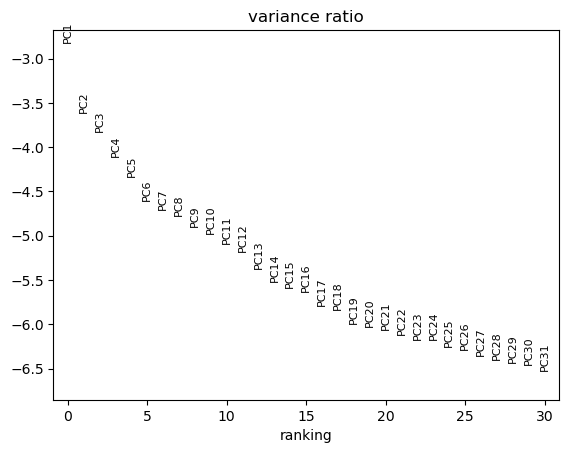

In [83]:
# Plot PCA elbow plot
sc.pl.pca_variance_ratio(adata_embryo, log=True)

In [84]:
adata_embryo.obs.condition.value_counts()

condition
mutant     13149
control     8774
Name: count, dtype: int64

In [42]:
adata.obs.stage.value_counts()

stage
embryo    21923
Name: count, dtype: int64

In [43]:
adata.obs.hSETBP1.value_counts()

hSETBP1
no     14615
yes     7308
Name: count, dtype: int64

In [44]:
adata.obs.columns

Index(['sample', 'condition', 'stage', 'hSETBP1', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'gene_UMI_ratio', 'log1p_gene_UMI_ratio', 'n_genes', 'n_counts'],
      dtype='object')

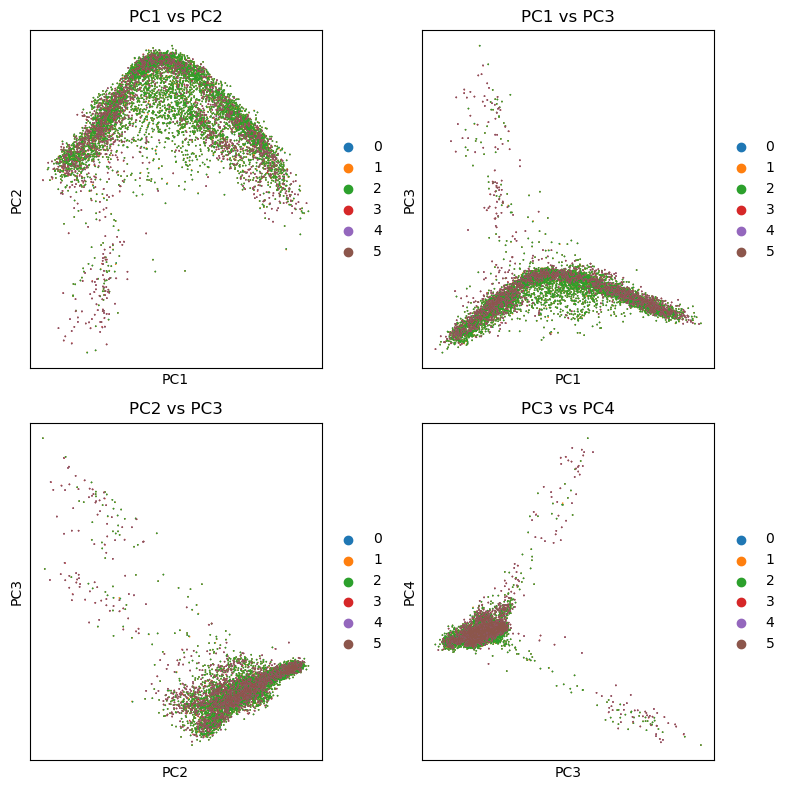

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sc.pl.pca(adata, color='sample', ax=axs[0, 0], show=False, title='PC1 vs PC2')
sc.pl.pca(adata, color='sample', ax=axs[0, 1], components=['1,3'], show=False, title='PC1 vs PC3')
sc.pl.pca(adata, color='sample', ax=axs[1, 0], components=['2,3'], show=False, title='PC2 vs PC3')
sc.pl.pca(adata, color='sample', ax=axs[1, 1], components=['3,4'], show=False, title='PC3 vs PC4')
plt.tight_layout()
plt.show()

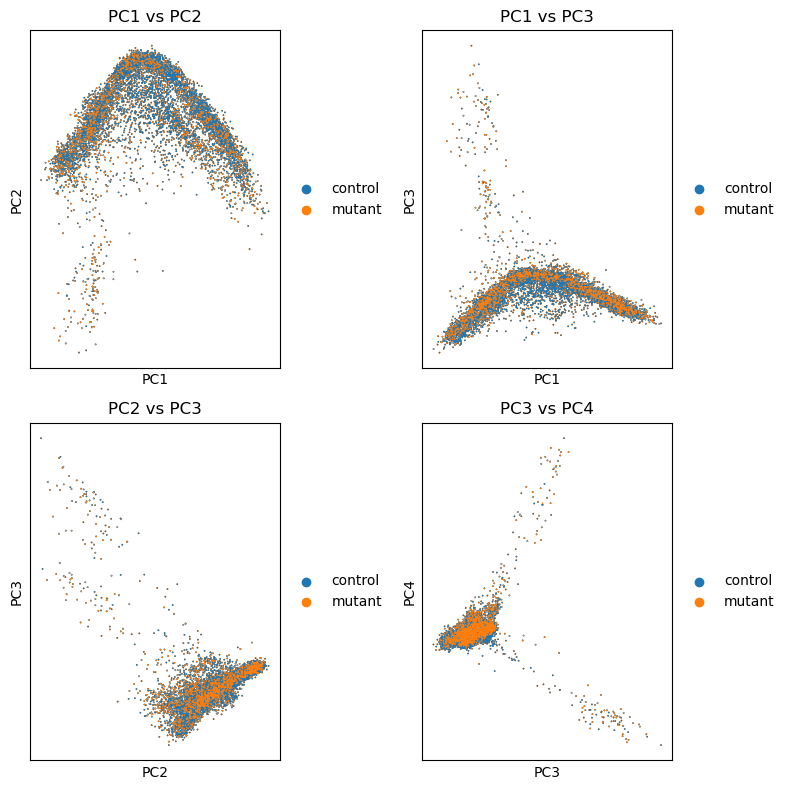

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sc.pl.pca(adata, color='condition', ax=axs[0, 0], show=False, title='PC1 vs PC2')
sc.pl.pca(adata, color='condition', ax=axs[0, 1], components=['1,3'], show=False, title='PC1 vs PC3')
sc.pl.pca(adata, color='condition', ax=axs[1, 0], components=['2,3'], show=False, title='PC2 vs PC3')
sc.pl.pca(adata, color='condition', ax=axs[1, 1], components=['3,4'], show=False, title='PC3 vs PC4')
plt.tight_layout()
plt.show()

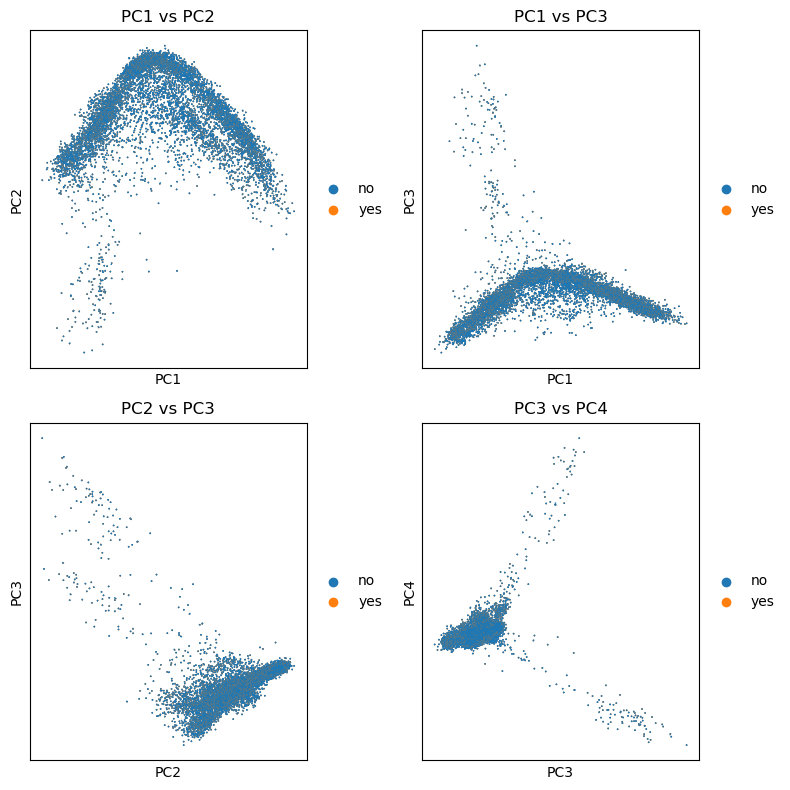

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sc.pl.pca(adata, color='hSETBP1', ax=axs[0, 0], show=False, title='PC1 vs PC2')
sc.pl.pca(adata, color='hSETBP1', ax=axs[0, 1], components=['1,3'], show=False, title='PC1 vs PC3')
sc.pl.pca(adata, color='hSETBP1', ax=axs[1, 0], components=['2,3'], show=False, title='PC2 vs PC3')
sc.pl.pca(adata, color='hSETBP1', ax=axs[1, 1], components=['3,4'], show=False, title='PC3 vs PC4')
plt.tight_layout()
plt.show()

In [57]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:24)


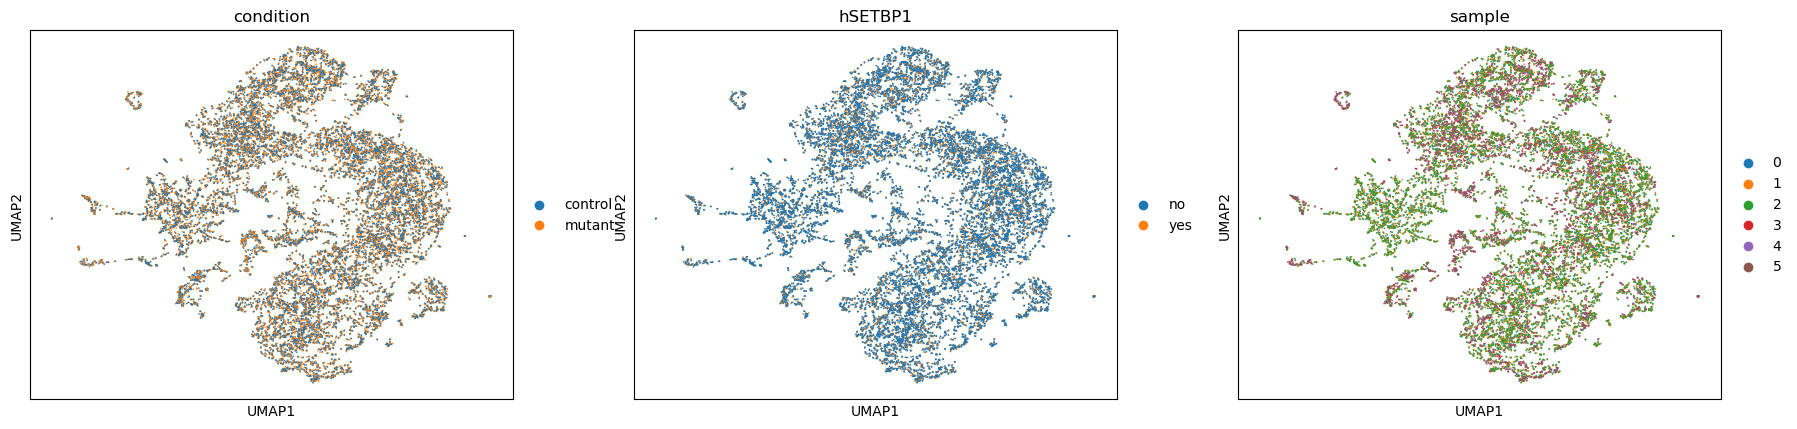

In [58]:
sc.pl.umap(adata, color=['condition', 'hSETBP1', 'sample'])

In [51]:
# sc.tl.leiden(adata)

In [52]:
# Perform differential gene expression analysis
sc.tl.rank_genes_groups(adata, 'condition', method='wilcoxon')

# Get the results
results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names

# Create a DataFrame with the results
dge_results = pd.DataFrame({
    group + '_' + key: results[key][group]
    for group in groups
    for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']
})

# Save the results to a CSV file
dge_results.to_csv('./output/dge_results.csv', index=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:29)


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


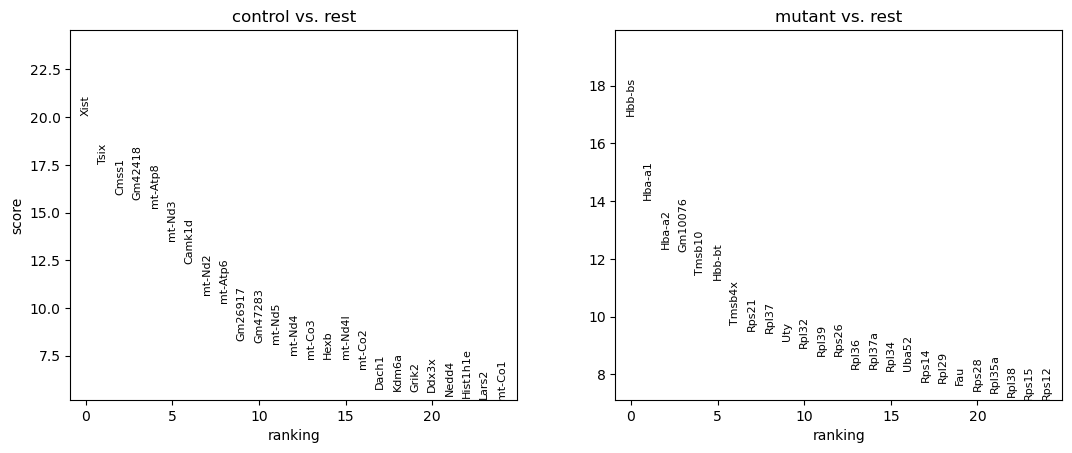

In [53]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:27)


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


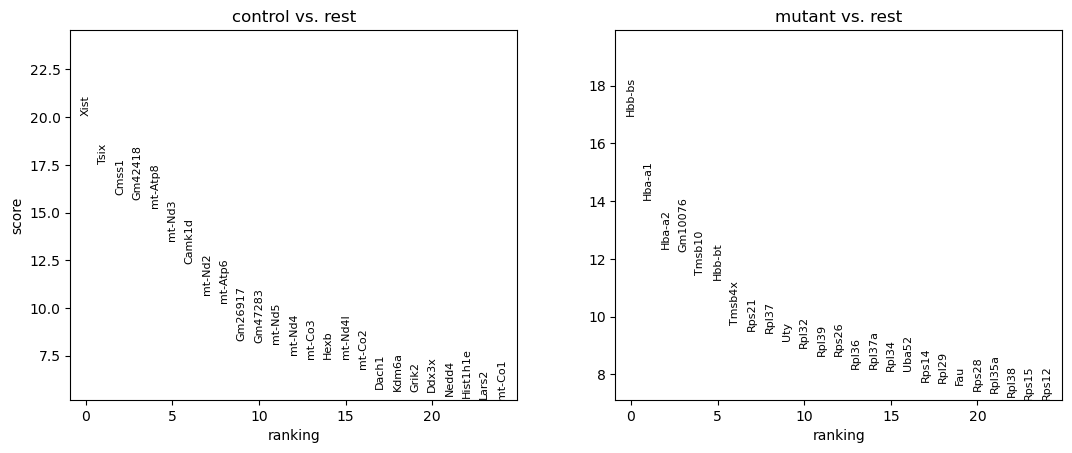

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:27)


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


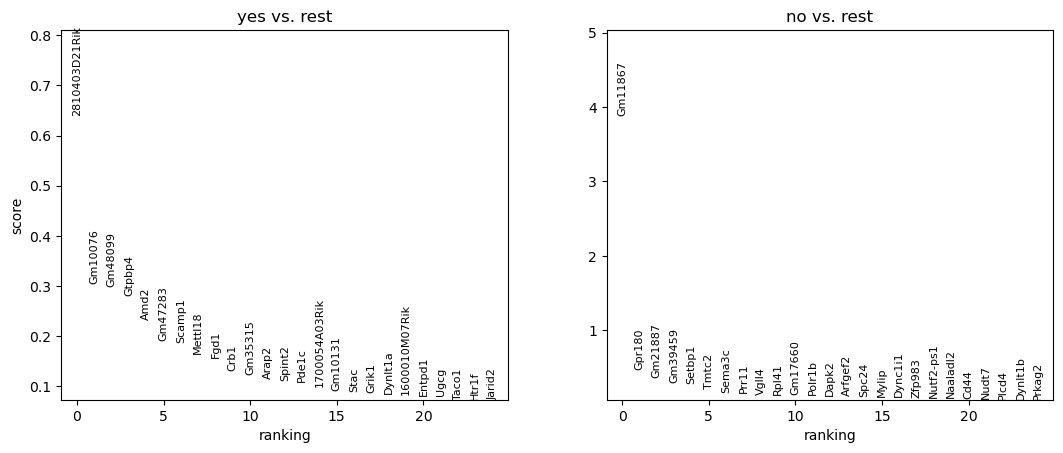

In [59]:
# Additional analysis: DGE for specific comparisons
comparisons = [
    ('condition', ['control', 'mutant']),
    ('hSETBP1', ['yes', 'no'])
]

for category, groups in comparisons:
    sc.tl.rank_genes_groups(adata, category, groups=groups, method='wilcoxon')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
    
    results = adata.uns['rank_genes_groups']
    dge_results = pd.DataFrame({
        group + '_' + key: results[key][group]
        for group in groups
        for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']
    })
    dge_results.to_csv(f'./output/dge_results_{category}.csv', index=False)

In [144]:
# Save the processed AnnData object
adata.write('./output/processed_data.h5ad')

# Legacy

In [ ]:
# Load and combine data from all samples
# adata_list = []
# for sample in sample_dirs[:1]:
#     sample_path = os.path.join(base_path, sample, "outs", "filtered_feature_bc_matrix")
#     adata = sc.read_10x_mtx(sample_path, var_names='gene_symbols', cache=True)
#     adata.obs['experiment'] = sample
#     adata_list.append(adata)

# adata = adata_list[0]

#############################################################################################

# # Load the scRNA-seq data from the h5 file
# h5_path = os.path.join(base_path, "AGG_Setbp1_hSETBP1", "outs", "filtered_feature_bc_matrix.h5")
# adata = sc.read_10x_h5(h5_path)

# # Add the experiment name to the observations
# adata.obs['experiment'] = 'AGG_Setbp1_hSETBP1'

# # Print basic information about the loaded data
# print(f"Loaded {adata.n_obs} cells and {adata.n_vars} genes from {h5_path}")